# Seedtag Datascience - Computer Vision Technical Test

In this technical test, you are asked to solve different Computer Vision tasks using the SVHN dataset:

1. For each task, we provide all the instructions and some sample code to perform basic operations and/or to clarify the problem. The provided code is implemented using libraries such as NumPy, PyTorch and PyTorchLightning. However, you are completely free to use any other library that you consider to solve the problems.

2. The solution for each exercise should be implemented in a JupyterNotebook similar as this one. You will need to submit a file called 'STData_CVision_Solution_YOURNAME.ipynb" when your test is finished. Additionally, you can also attach a zip file with other data (figures,images, reports) that you have generated if you consider them relevant ( conveniently reference and discussed in the notebook) .

3. It is very important that, apart from solving the task, you also motivate the different decisions that you take when solving them and discuss properly the different results that you obtain.

Good luck!!!



# 0. Package installation and SVHN Dataset downloading

Installation of basic packages to run the provided examples. If you use any other libraries, you can modify the following list accordingly.

In [2]:
# %pip install scipy
# %pip install torch
# %pip install torchvision
# %pip install scipy
# %pip install numpy
# %pip install pytorch_lightning
# %pip install torchmetrics
# %pip install matplotlib
# %pip install IProgress
# %pip install ipywidgets


In [3]:
import torchvision

torchvision.datasets.SVHN('./data','train',download=True)
torchvision.datasets.SVHN('./data','test',download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data
    Split: test

# 1. SVHN Dataset

1. The SVHN dataset contains 32x32 pixels color images depicting digits from 0 to 9.
2. The original training and testing splits contain ~73K and ~26K images, respectively. The digit labels for each split and image are also provided
3. Two files containing the images and labels from both splits are saved in the "./data" folder as numpy arrays.

For each task in the test, you will need to use different splits of the dataset. In the following, we provide the code to load the different splits and an example of how to visualize images.



## 1.1 Loading a specific split for a given task



In [1]:
import os 
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
def load_data(root_dir, split):
    
    filename = os.path.join(root_dir,'test_32x32.mat')
    if(split.startswith('train') or split.startswith('unlabelled')):
        filename = os.path.join(root_dir,'train_32x32.mat') 
    elif(split.startswith('test')):
        filename = os.path.join(root_dir,'test_32x32.mat')
    
    loaded_mat = sio.loadmat(filename)
    imgs = (loaded_mat['X']/255).astype(np.float32)
    labels = loaded_mat['y'].astype(np.int64).squeeze()
    if(split=='train_29_task2'):
        imgs_idx_01 =  np.logical_or(labels==10,labels==1)
        imgs_idx_29 = np.where(np.logical_not(imgs_idx_01))
        imgs = imgs[:,:,:,imgs_idx_29]
        labels = labels[imgs_idx_29]
    elif(split=='test_01_task2' or split=='train_01_task2'):
        imgs_idx_01 =  np.where(np.logical_or(labels==10,labels==1))[0]
        if(split=='train_01_task2'):
            imgs_idx_01 = imgs_idx_01[0:200]
        else:
            imgs_idx_01 = imgs_idx_01[200::]
        imgs = imgs[:,:,:,imgs_idx_01]
        labels = labels[imgs_idx_01]
    if(split=='test_task3'):
        N = 50
        imgs = imgs[:,:,:,0:N]
        labels = labels[0:N]
    print('Loaded SVHN split: {split}'.format(split=split))
    print('-------------------------------------')
    print('Images Size: ' , imgs.shape[0:-1])
    print('Split Number of Images:', imgs.shape[-1])
    print('Split Labels Array Size:', labels.shape)
    print('Possible Labels: ', np.unique(labels))
    return imgs,labels
#
# split_images, split_labels = load_data('./data','train_29_task2')
# split_images, split_labels = load_data('./data','test_01_task2')
# split_images, split_labels = load_data('./data','train_01_task2')
# #
split_images, split_labels = load_data('./data','test_01_task2')


Loaded SVHN split: test_01_task2
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 6643
Split Labels Array Size: (6643,)
Possible Labels:  [ 1 10]


## 1.2 VIsualizing images and their labels

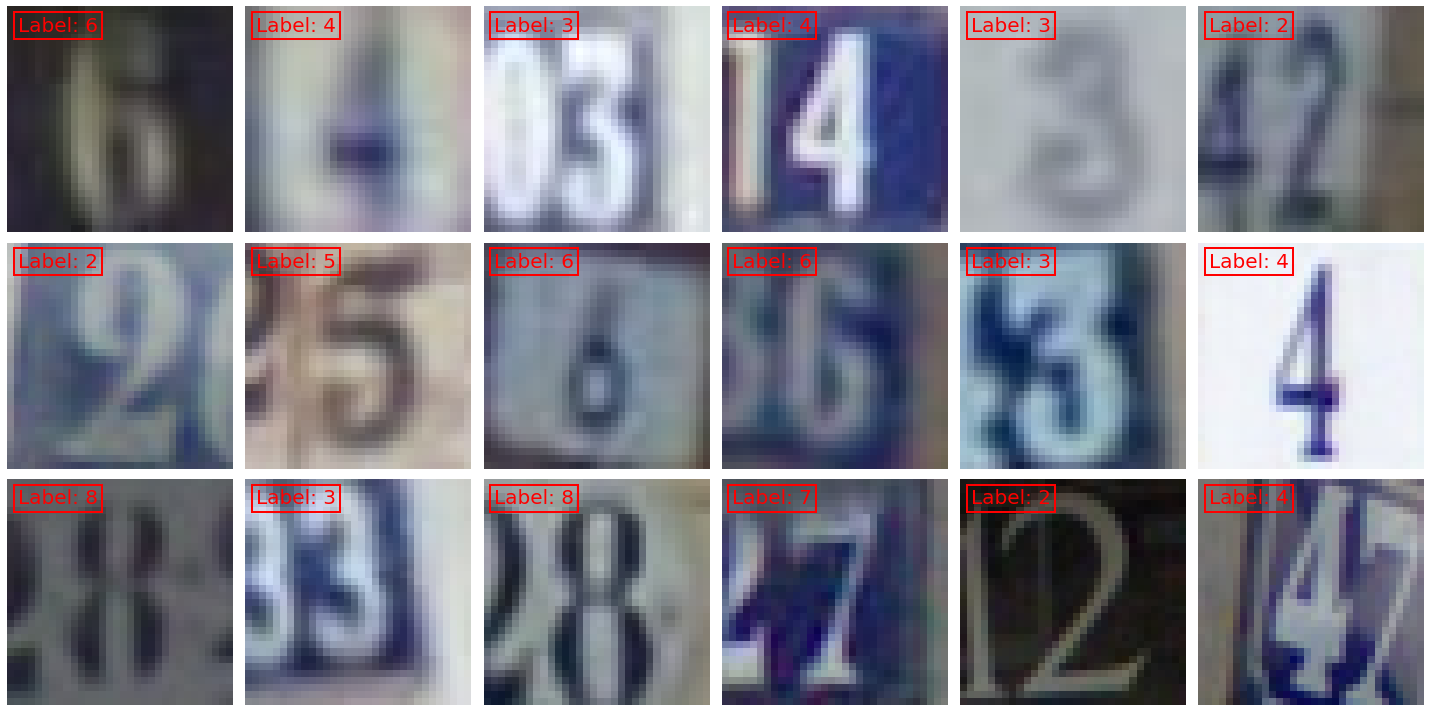

In [5]:
# Example: Visualize images and its labels
def visualize_image(images, labels, index):
    img = images[:,:,:,index]
    label = labels[index]
    plt.imshow((img))
    plt.text(1, 3, 'Label: {label}'.format(label=label), c = 'red', fontsize= 20,
             bbox=dict(fill=False, edgecolor='red', linewidth=2))
    plt.axis('off')
    

plt.subplots(figsize=(20,10))
for idx, image_index in enumerate(np.random.randint(0, split_images.shape[-1], 18)):
    plt.subplot(3,6,idx+1)
    visualize_image(split_images,
                split_labels,
                image_index)
plt.tight_layout()
plt.show()


In [5]:
split_images.shape

(32, 32, 3, 73257)

# Task 1 (T1) - Image Classification

In this task, the goal is to create  a classification model to identify the digit labels for each image. For this purpose, you are provided with:
1. A training set corresponding to the original train split of the SVHN dataset (previously introduced)
2. A testing set corresponding to the original test split. 

With the provided data, you need to develop a model classifying images into the different digit classes. Your goal is to obtain the maximum possible accuracy in the testing set with the following instructions:
1. You can use any existing implemented method and any external library that you consider.
2. The testing set can only be used for evaluation puproses.
3. In case that you train a parametric model (e.g, a neural network), it can not contain more than 200K parameters.
3. Apart from accuracy, you can also report and discuss any other evaluation metric that you consider relevant.

## T1.1 - Pytorch Example

In the following, we provide a simple solution to the task by training a Multi-Layer perceptron with a single hidden layer using:
1. A cross entropy loss during learning.
2. A hidden layer with 64 neurons and a Rectified Linear Unit activation function.
2. Stochastic Gradient Descent for optimization with learning rate of 5e-2 and a batch size of 64 samples

### T1.1.1 - SVHN Dataset class

Implementation example of a PyTorch dataset class to load the different SVHN splits 

In [9]:
import os 
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import scipy.io as sio
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

class SVHNDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, 
                 root_dir, 
                 split, 
                 transform=None):
        self.images, self.labels = load_data(root_dir, split)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img, target = self.images[:,:,:,index], int(self.labels[index])
        if self.transform:
            img = self.transform(img)
        return img, target-1 # target -1 assuming that there are no 0s

train_dataset = SVHNDataset('./data','train_task1',
                            transform = transforms.ToTensor())
img_index = 100 
visualize_image(train_dataset.images, 
                train_dataset.labels, 
                img_index)


KeyboardInterrupt: 

### T1.1.2 - Model definition with Pytorch Lightning
Implementation example using Pytorch Lightning of a Neural Network composed of single fully-connected hidden layer.

In [7]:
import pytorch_lightning as pl
import torch.nn as nn
from  torch.utils.data import DataLoader
import torchmetrics
class MLP(pl.LightningModule):
    def __init__(self, 
                 in_features, 
                 hidden_features, 
                 n_classes):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_features)
        self.layer2 = nn.Linear(hidden_features, n_classes)
        self.activation = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        h = self.activation(self.layer1(x))
        out = self.layer2(h)
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=5e-2)
        return optimizer
    
    def compute_step(self,batch):
        imgs, labels = batch
        imgs = imgs.view(imgs.size(0), -1)
        label_logits = self.forward(imgs)
        _,label_predictions = torch.max(label_logits, dim=1 )
        return self.loss(label_logits,labels), labels, label_predictions
    
    def training_step(self, train_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(train_batch)
        self.train_accuracy(label_predictions, labels)
        self.log_dict({"train/loss": loss, 'train/acc' : self.train_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(val_batch)
        self.val_accuracy(label_predictions, labels)
        self.log_dict({"val/loss": loss, 'val/acc' : self.val_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss
    
        

### T1.1.3 Model training/evaluation and visualizantion with tensorboard 
Example of training the defined model with Pytorch Lightning, logging training and evaluation metrics and visualizing them with Tensorboard 

In [8]:
from pytorch_lightning import loggers as pl_loggers

train_data_ex1 = SVHNDataset('./data','train_task1',
                             transform = transforms.ToTensor())
test_data_ex1 = SVHNDataset('./data','test_task1',
                            transform = transforms.ToTensor())

train_loader = DataLoader(train_data_ex1, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data_ex1, batch_size=64, shuffle=False)

in_features = 32*32*3
hidden_features = 64
n_classes = 10 
model = MLP(in_features,
            hidden_features,
            n_classes)

tb_logger = pl_loggers.TensorBoardLogger("./logs/")
trainer = pl.Trainer(gpus=1,max_epochs=10,logger = tb_logger)
trainer.fit(model, 
           train_loader, 
           test_loader)



Loaded SVHN split: train_task1
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 73257
Split Labels Array Size: (73257,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded SVHN split: test_task1
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 26032
Split Labels Array Size: (26032,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | layer1         | Linear           | 196 K 
1 | layer2         | Linear           | 650   
2 | activation     | ReLU             | 0     
3 | loss           | CrossEntropyLoss | 0     
4 | train_accuracy | Accuracy         | 0     
5 | val_accuracy   | Accuracy         | 0     
----------------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.789     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### T1.2 - Training and testing results visualized on tensorboard

In [10]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 22305), started 0:00:08 ago. (Use '!kill 22305' to kill it.)

As can be observed, the model contains 196K parameters which is under the contraints given by the exercise.
Additionally, the model achieves around a 60% accuracy on the validation set as can be visualized in the Tensorboad Dashboard

# Task 2 - Image Classification with scarce training data
In this task, the goal is to create a model which is able to perform binary classification and differentiate between images depicting the digit 0 or 1. For this purpose, you are provided with:
1. A training set containing images with digits from 2 to 9. This dataset is large and is composed by a total of XXX examples. 
2. A training set containing images with digits from 0 to 1. This split is small and only contains XXX examples.
3. A testing set with image digits from 0 to 1. This dataset is larger than the previous one and must be used for evaluation purposes. 

With the provided data, train the model classifying 0 and 1s and evaluate its performance in terms of accuracy. Your goal is to obtain the maximum possible accuracy in the testing set by following the model constratints described in Task 1.

### T2.1 - Loading datasets from the different splits 

In [11]:
from torchvision.datasets import SVHN

train_29_imgs, train_29_labels = load_data('./data','train_29_task2')
train_01_imgs, train_01_labels = load_data('./data','train_01_task2')
test_01_imgs, test_01_labels = load_data('./data','test_01_task2')


Loaded SVHN split: train_29_task2
-------------------------------------
Images Size:  (32, 32, 3, 1)
Split Number of Images: 54448
Split Labels Array Size: (54448,)
Possible Labels:  [2 3 4 5 6 7 8 9]
Loaded SVHN split: train_01_task2
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 200
Split Labels Array Size: (200,)
Possible Labels:  [ 1 10]
Loaded SVHN split: test_01_task2
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 6643
Split Labels Array Size: (6643,)
Possible Labels:  [ 1 10]


# Task 3 - Image Classification with unlabelled training data
In this task, you are provided with the following data splits:

1. An unlabelled set containing images with digits from 0 to 9. This dataset corresponds to the original SVHN training set.  
2. A small subset of 50 unlabelled images with digits also ranging from 0 to 9.

Given any query image $\mathbf{x}$ in the small unlabelled dataset, your goal is to estimate what are the 5 most similar images in the large unlabelled dataset. Intuitively, you are interested in retrieving images which contain the same digit than the query image. For instance, if the query image contains the digit 0, you would like that the 5 retrieved images depict the number 0. 

The goal is to maximize a metric measuring the percentage of retrieved images that correspond to the same digit label than the query image. 
However, it is important to  remember that both splits are assumed to not be annotated and that you can only use the provided labels for evaluation purposes.

### T3.1 - Solution example comparing images using euclidean distance
In the following, we provide a simple solution to this problem by:
1. Computing the distance in terms of L2 distance between the  query image and all the images in the large unlabelled dataset.
2. Retrieving the top 5 images with the minimum distance.

We also provide an example of how to visualize results and compute the target metric. 

In [12]:
import os 
import scipy.io as sio
import numpy as np

# Load both splits
unlabelled_imgs, unlabelled_labels = load_data('./data','unlabelled_task3')
test_imgs, test_labels = load_data('./data','test_task3')

# Vectorize all the images in both splits
unlabelled_imgs_T = unlabelled_imgs.reshape(-1,unlabelled_imgs.shape[-1]).T
test_imgs_T = test_imgs.reshape(-1,test_imgs.shape[-1]).T

Loaded SVHN split: unlabelled_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 73257
Split Labels Array Size: (73257,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Loaded SVHN split: test_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 50
Split Labels Array Size: (50,)
Possible Labels:  [ 1  2  3  4  5  6  8  9 10]


Query Image
Retrieved Similar Images


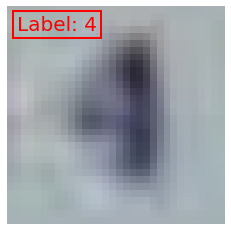

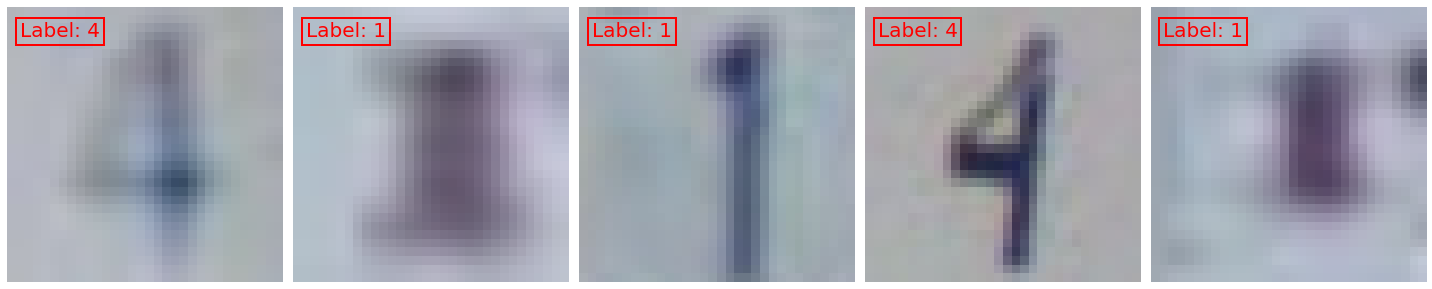

: 

In [23]:
# Visualize the TOP5 retrieved images for a given quary using euclidean distance-based similarity
K = 5

# Load a given query image form the test set
img_idx = np.random.randint(low=0, high=test_imgs_T.shape[0])
img = test_imgs_T[img_idx,:]


# Compute euclidean metric
distances = ((unlabelled_imgs_T-img)**2).sum(axis=1)

# Get top10 most similar images
similar_img_idx = (distances).argsort()[:K]

# Visualize images
print('Query Image')
visualize_image(test_imgs, test_labels,
                img_idx)
print('Retrieved Similar Images')
# for idx in similar_img_idx:
    
#     visualize_image(unlabelled_imgs, unlabelled_labels,
#                     idx)

plt.subplots(figsize=(20,10))
for i, idx in enumerate(similar_img_idx):
    plt.subplot(1,5,i+1)
    visualize_image(unlabelled_imgs, unlabelled_labels,
                    idx)
plt.tight_layout()
plt.show()



In [15]:
img_accuracies = [] 
K = 5
N = test_imgs.shape[0]
for img_idx in range(0,N):
    img = test_imgs_T[img_idx,:]
    distances = ((unlabelled_imgs_T-img)**2).sum(axis=1)
    idx = (distances).argsort()[:K]
    similar_img_labels = unlabelled_labels[idx]
    img_label = test_labels[img_idx]
    image_accuracy = (similar_img_labels==img_label).mean()
    img_accuracies.append(image_accuracy)
    print('Accuracy for test sample {idx} with label {label}  in TOP{K} retrieved images: {acc}'.format(idx=img_idx,
                                                                                                        label= img_label,
                                                                                                        K=K,
                                                                                                        acc = image_accuracy))

# Compute average accuracy over testing set    
average_acc = np.asarray(img_accuracies).mean()
print('Average Accuracy over the testing set: {acc}'.format(acc=average_acc))

Accuracy for test sample 0 with label 5  in TOP5 retrieved images: 0.0
Accuracy for test sample 1 with label 2  in TOP5 retrieved images: 0.6
Accuracy for test sample 2 with label 1  in TOP5 retrieved images: 0.8
Accuracy for test sample 3 with label 10  in TOP5 retrieved images: 0.0
Accuracy for test sample 4 with label 6  in TOP5 retrieved images: 0.4
Accuracy for test sample 5 with label 1  in TOP5 retrieved images: 0.6
Accuracy for test sample 6 with label 9  in TOP5 retrieved images: 0.2
Accuracy for test sample 7 with label 1  in TOP5 retrieved images: 0.8
Accuracy for test sample 8 with label 1  in TOP5 retrieved images: 0.8
Accuracy for test sample 9 with label 8  in TOP5 retrieved images: 0.2
Accuracy for test sample 10 with label 3  in TOP5 retrieved images: 0.0
Accuracy for test sample 11 with label 6  in TOP5 retrieved images: 0.2
Accuracy for test sample 12 with label 5  in TOP5 retrieved images: 0.2
Accuracy for test sample 13 with label 1  in TOP5 retrieved images: 0.8
A